In [21]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from category_encoders import TargetEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [22]:
# Load dataset
df = pd.read_csv("/kaggle/input/liar-dataset/train.tsv", sep="\t", header=None)
df.columns = ["id","label","statement","subjects","speaker","speaker_job","state","party",
              "barely_true_counts","false_counts","half_true_counts","mostly_true_counts",
              "pants_on_fire_counts","context"]

# Binary label
true_labels = ["true", "mostly-true", "half-true"]
df["binary_label"] = df["label"].apply(lambda x: "true" if x in true_labels else "false")

In [23]:
# Preprocess text function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Clean text columns
df["clean_statement"] = df["statement"].apply(preprocess)
df["clean_subjects"] = df["subjects"].fillna("").apply(preprocess)
df["clean_context"] = df["context"].fillna("").apply(preprocess)

# TF-IDF for text columns
tfidf_statement = TfidfVectorizer(max_features=12000, ngram_range=(1,3), min_df=3, max_df=0.9)
X_statement = tfidf_statement.fit_transform(df["clean_statement"])

tfidf_subjects = TfidfVectorizer(max_features=5000)
X_subjects = tfidf_subjects.fit_transform(df["clean_subjects"])

tfidf_context = TfidfVectorizer(max_features=5000)
X_context = tfidf_context.fit_transform(df["clean_context"])

# Numeric features scaled
numeric_cols = ["barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts"]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_cols].fillna(0))

# Target encoding for speaker and speaker_job
te_speaker = TargetEncoder()
df['speaker_encoded'] = te_speaker.fit_transform(df['speaker'], df['binary_label'].map({'false':0,'true':1}))

te_job = TargetEncoder()
df['speaker_job_encoded'] = te_job.fit_transform(df['speaker_job'], df['binary_label'].map({'false':0,'true':1}))


Generating TextBlob features...


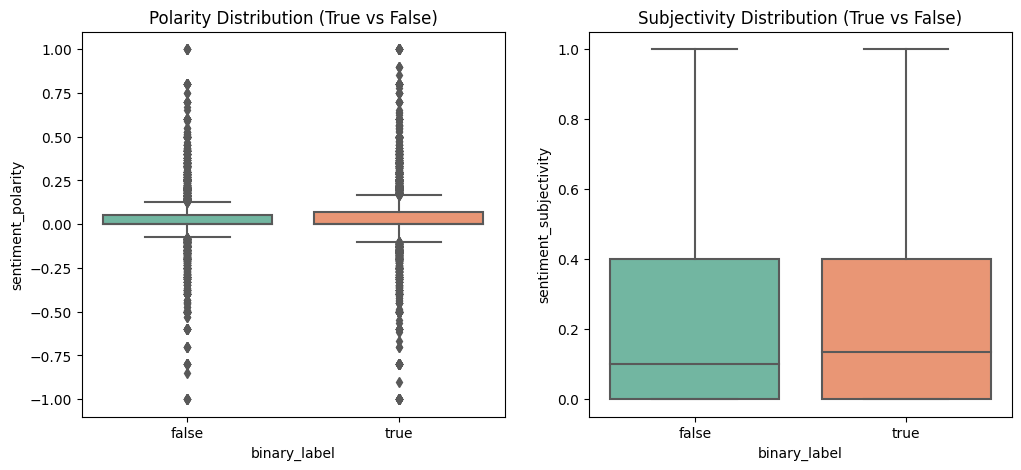

In [24]:
from textblob import TextBlob
import numpy as np

# Function to get polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

# Apply to the 'clean_statement'
print("Generating TextBlob features...")
df[['sentiment_polarity', 'sentiment_subjectivity']] = df['clean_statement'].apply(get_sentiment)

# Visualize: Do True vs False statements differ in sentiment?
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='binary_label', y='sentiment_polarity', data=df, ax=axes[0], palette="Set2")
axes[0].set_title('Polarity Distribution (True vs False)')

sns.boxplot(x='binary_label', y='sentiment_subjectivity', data=df, ax=axes[1], palette="Set2")
axes[1].set_title('Subjectivity Distribution (True vs False)')

plt.show()

In [25]:
# One-hot encoding for state and party
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_cat = ohe.fit_transform(df[['state','party']].fillna("unknown"))

# Combine all features
import numpy as np
X_combined = hstack([X_statement, X_subjects, X_context, X_numeric, 
                     np.array(df[['speaker_encoded','speaker_job_encoded']]), X_cat])

# Labels
le = LabelEncoder()
y_numeric = le.fit_transform(df["binary_label"])

In [26]:
# 1. Scale the new TextBlob features
scaler_sent = StandardScaler()
X_sentiment = scaler_sent.fit_transform(df[['sentiment_polarity', 'sentiment_subjectivity']])

# 2. Update the hstack to include X_sentiment
# We reconstruct the stack using your existing matrices + the new one
X_combined_with_tb = hstack([
    X_statement, 
    X_subjects, 
    X_context, 
    X_numeric, 
    np.array(df[['speaker_encoded','speaker_job_encoded']]), 
    X_cat,
    X_sentiment  # <--- NEW ADDITION
])

# 3. New Train-Test Split
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(
    X_combined_with_tb, y_numeric, test_size=0.2, random_state=42
)

# 4. Retrain XGBoost with Sentiment Features
print("Training XGBoost with TextBlob features...")
xgb_tb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, eval_metric='logloss')
xgb_tb.fit(X_train_tb, y_train_tb)
xgb_pred_tb = xgb_tb.predict(X_test_tb)

# 5. Evaluate
print(f"=== XGBoost with TextBlob ===")
print("Accuracy:", accuracy_score(y_test_tb, xgb_pred_tb))
print("F1 Score:", f1_score(y_test_tb, xgb_pred_tb, average="macro"))
print(classification_report(y_test_tb, xgb_pred_tb))

# 6. Check Feature Importance of the new features
# We need to calculate the index of the new features. 
# They are added at the very end of the matrix.
total_features = X_combined_with_tb.shape[1]
subjectivity_idx = total_features - 1
polarity_idx = total_features - 2

importances_tb = xgb_tb.feature_importances_

print(f"Feature Importance - Polarity: {importances_tb[polarity_idx]:.6f}")
print(f"Feature Importance - Subjectivity: {importances_tb[subjectivity_idx]:.6f}")

Training XGBoost with TextBlob features...
=== XGBoost with TextBlob ===
Accuracy: 0.74462890625
F1 Score: 0.7371703875980025
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       888
           1       0.76      0.81      0.78      1160

    accuracy                           0.74      2048
   macro avg       0.74      0.74      0.74      2048
weighted avg       0.74      0.74      0.74      2048

Feature Importance - Polarity: 0.000872
Feature Importance - Subjectivity: 0.000656


=== Logistic Regression ===
Accuracy: 0.734375
F1 Score: 0.7300915270826166
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       888
           1       0.77      0.76      0.76      1160

    accuracy                           0.73      2048
   macro avg       0.73      0.73      0.73      2048
weighted avg       0.73      0.73      0.73      2048



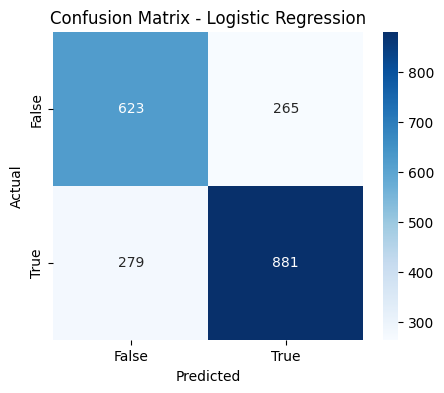

=== XGBoost ===
Accuracy: 0.74951171875
F1 Score: 0.7421958103972759
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       888
           1       0.76      0.81      0.79      1160

    accuracy                           0.75      2048
   macro avg       0.75      0.74      0.74      2048
weighted avg       0.75      0.75      0.75      2048



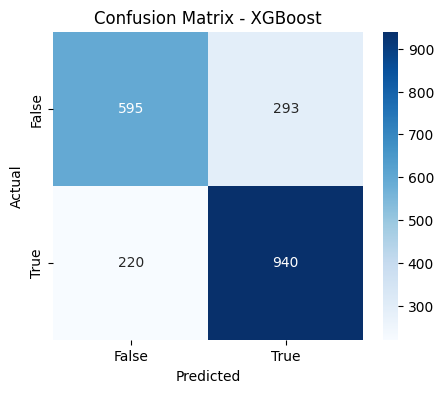

Top words predicting TRUE: ['say' 'state' 'percent' 'year' 'tax' '000' 'million' 'job' 'country'
 'american' 'people' 'obama' 'one' 'time' 'health' 'president' 'since'
 'texas' 'rate' 'every']
Top words predicting FALSE: ['say' 'state' 'obama' 'tax' 'year' 'president' 'percent' 'health' 'care'
 'people' 'job' '000' 'barack' 'would' 'bill' 'health care' 'government'
 'million' 'one' 'barack obama']
Top 20 important features (XGBoost):
11961: Importance=0.014367541298270226
3484: Importance=0.004478593356907368
11957: Importance=0.00444983784109354
6856: Importance=0.0037715064827352762
4020: Importance=0.0036749530117958784
11747: Importance=0.0036362488754093647
11026: Importance=0.0035283558536320925
11958: Importance=0.0035231958609074354
9576: Importance=0.0035189534537494183
4045: Importance=0.0034679186064749956
4238: Importance=0.0034160420764237642
1493: Importance=0.003358758520334959
64: Importance=0.0033475442323833704
10262: Importance=0.0032898036297410727
5372: Importance=

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_numeric, test_size=0.2, random_state=42)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Evaluate models
models = {"Logistic Regression": log_pred, "XGBoost": xgb_pred}
for name, pred in models.items():
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("F1 Score:", f1_score(y_test, pred, average="macro"))
    print(classification_report(y_test, pred))
    
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False","True"], yticklabels=["False","True"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Display top TF-IDF features for TRUE and FALSE from statements
import numpy as np
feature_array = np.array(tfidf_statement.get_feature_names_out())
true_class_idx = np.where(y_numeric==1)[0]
false_class_idx = np.where(y_numeric==0)[0]
tfidf_mean_true = np.array(X_statement[true_class_idx].mean(axis=0)).flatten()
tfidf_mean_false = np.array(X_statement[false_class_idx].mean(axis=0)).flatten()

top_true_idx = tfidf_mean_true.argsort()[-20:][::-1]
top_false_idx = tfidf_mean_false.argsort()[-20:][::-1]

print("Top words predicting TRUE:", feature_array[top_true_idx])
print("Top words predicting FALSE:", feature_array[top_false_idx])

# Feature importance from XGBoost
importances = xgb.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]
print("Top 20 important features (XGBoost):")
for idx in top_idx:
    print(f"{idx}: Importance={importances[idx]}")



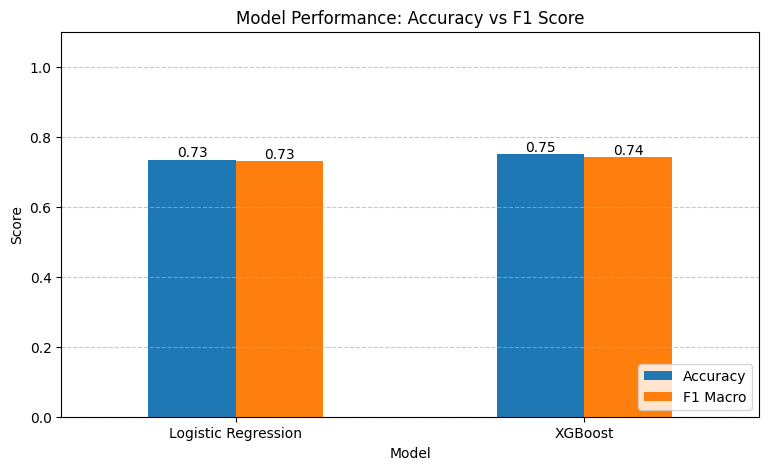

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a dataframe for plotting
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, log_pred), accuracy_score(y_test, xgb_pred)],
    'F1 Macro': [f1_score(y_test, log_pred, average="macro"), f1_score(y_test, xgb_pred, average="macro")]
})

# Plotting
ax = results_df.set_index('Model').plot(kind='bar', figsize=(9, 5), color=['#1f77b4', '#ff7f0e'])
plt.title('Model Performance: Accuracy vs F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Add labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

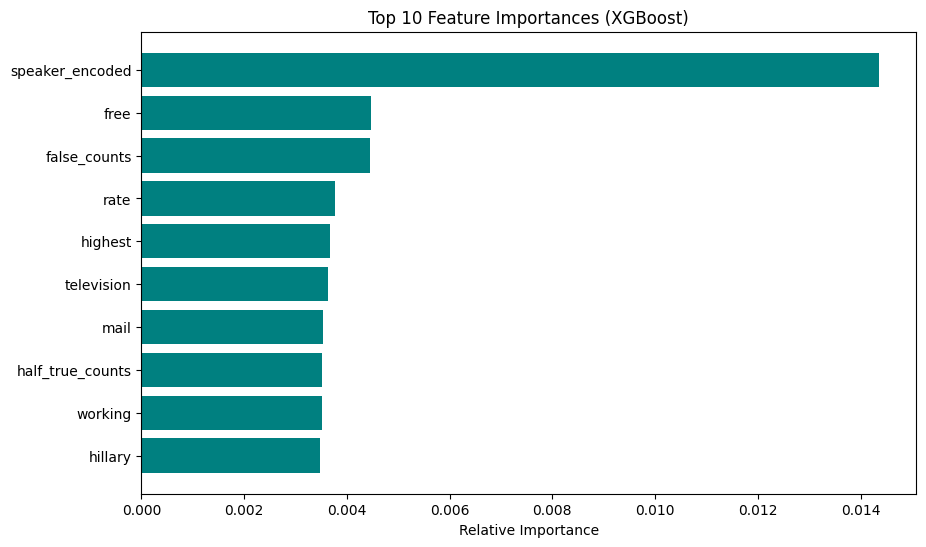

In [29]:
# 1. Gather all feature names in the exact order of hstack
names_statement = tfidf_statement.get_feature_names_out()
names_subjects = tfidf_subjects.get_feature_names_out()
names_context = tfidf_context.get_feature_names_out()
names_numeric = numeric_cols
names_speakers = ['speaker_encoded', 'speaker_job_encoded']
names_cat = ohe.get_feature_names_out()

# Combine them
all_feature_names = np.concatenate([
    names_statement, 
    names_subjects, 
    names_context, 
    names_numeric, 
    names_speakers, 
    names_cat
])

# 2. Map importance to names
importances = xgb.feature_importances_
indices = np.argsort(importances)[-10:] # Top 10

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The figure layout has changed to tight


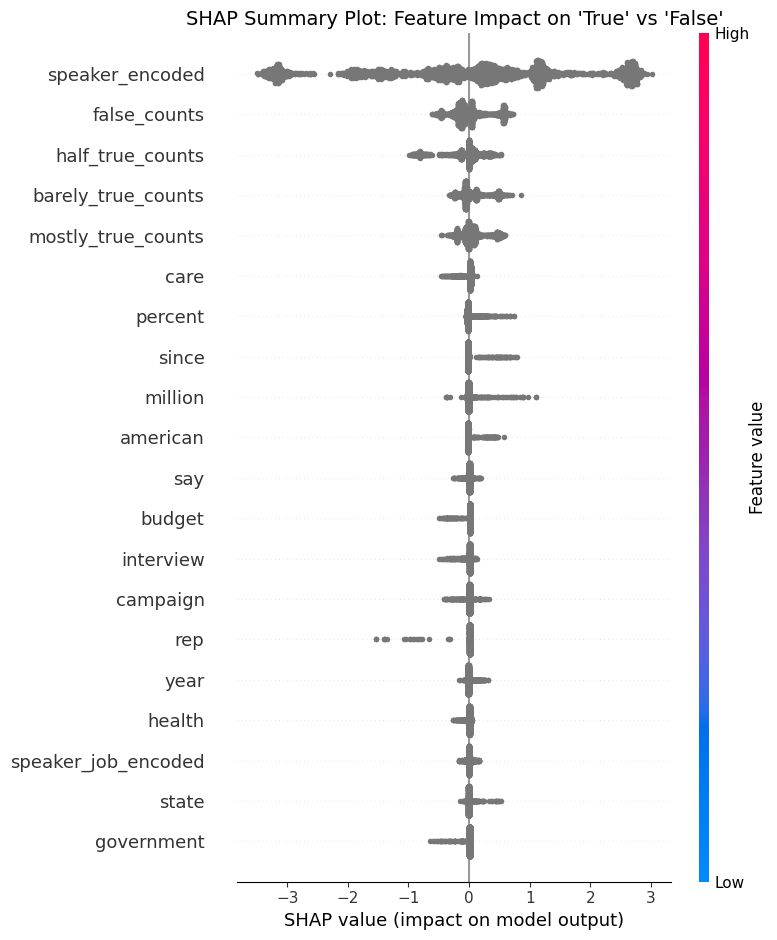

In [30]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Re-generate feature names (Crucial so the plot isn't just "Feature 0, Feature 1")
# (This logic mirrors your hstack structure)
names_statement = tfidf_statement.get_feature_names_out()
names_subjects = tfidf_subjects.get_feature_names_out()
names_context = tfidf_context.get_feature_names_out()
names_numeric = numeric_cols # ["barely_true_counts", "false_counts", etc.]
names_speakers = ['speaker_encoded', 'speaker_job_encoded']
names_cat = ohe.get_feature_names_out()

all_feature_names = np.concatenate([
    names_statement, 
    names_subjects, 
    names_context,
    names_numeric, 
    names_speakers, 
    names_cat
])

# 2. Initialize the SHAP Explainer with your XGBoost model
# We use a subset of X_test (e.g., first 1000 rows) to speed up calculation if dataset is huge
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# 3. Create the Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names, show=False)
plt.title("SHAP Summary Plot: Feature Impact on 'True' vs 'False'", fontsize=14)
plt.tight_layout()
plt.show()

Step 1: Extracting Sentiment Features...


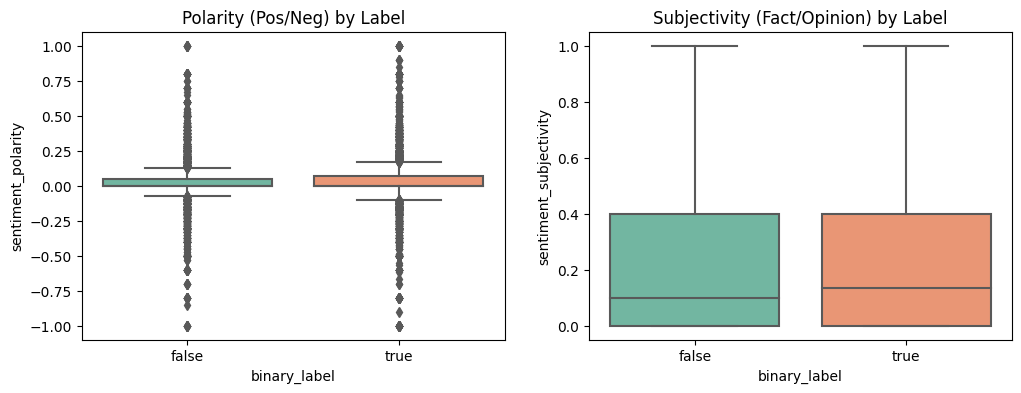

Step 2: Stacking Features...
Step 3: Training XGBoost with Sentiment...

=== FINAL RESULTS: XGBoost + TextBlob ===
Accuracy: 0.74463
F1 Score: 0.73717
------------------------------
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       888
           1       0.76      0.81      0.78      1160

    accuracy                           0.74      2048
   macro avg       0.74      0.74      0.74      2048
weighted avg       0.74      0.74      0.74      2048



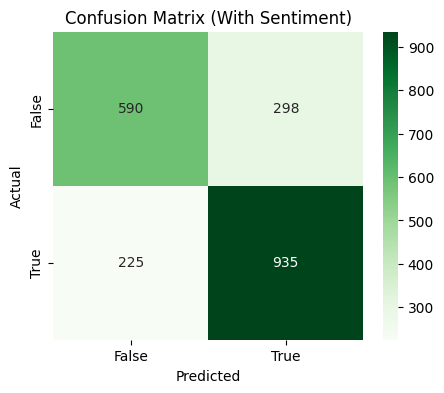

Importance of Subjectivity: 0.000656
Importance of Polarity:     0.000872


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ==========================================
# 1. FEATURE ENGINEERING: SENTIMENT ANALYSIS
# ==========================================
print("Step 1: Extracting Sentiment Features...")

def get_sentiment(text):
    # Returns (Polarity, Subjectivity)
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

# Apply to dataframe
df[['sentiment_polarity', 'sentiment_subjectivity']] = df['clean_statement'].apply(get_sentiment)

# Visualize the separation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='binary_label', y='sentiment_polarity', data=df, ax=axes[0], palette="Set2")
axes[0].set_title('Polarity (Pos/Neg) by Label')
sns.boxplot(x='binary_label', y='sentiment_subjectivity', data=df, ax=axes[1], palette="Set2")
axes[1].set_title('Subjectivity (Fact/Opinion) by Label')
plt.show()

# ==========================================
# 2. PREPARE & STACK FEATURES
# ==========================================
print("Step 2: Stacking Features...")

# Scale the new features
scaler_sent = StandardScaler()
X_sentiment = scaler_sent.fit_transform(df[['sentiment_polarity', 'sentiment_subjectivity']])

# Combine with ALL previous features
# Note: Ensure these variables (X_statement, etc.) exist from your previous cells
X_combined_tb = hstack([
    X_statement, 
    X_subjects, 
    X_context, 
    X_numeric, 
    np.array(df[['speaker_encoded', 'speaker_job_encoded']]), 
    X_cat,
    X_sentiment  # <--- The new TextBlob features
])

# ==========================================
# 3. SPLIT & TRAIN
# ==========================================
print("Step 3: Training XGBoost with Sentiment...")

# Split (using same seed '42' for fair comparison)
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(
    X_combined_tb, y_numeric, test_size=0.2, random_state=42
)

# Initialize & Fit XGBoost
xgb_tb = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6, 
    eval_metric='logloss',
    n_jobs=-1
)
xgb_tb.fit(X_train_tb, y_train_tb)

# Predict
xgb_pred_tb = xgb_tb.predict(X_test_tb)

# ==========================================
# 4. EVALUATION
# ==========================================
print("\n=== FINAL RESULTS: XGBoost + TextBlob ===")
acc = accuracy_score(y_test_tb, xgb_pred_tb)
f1 = f1_score(y_test_tb, xgb_pred_tb, average="macro")

print(f"Accuracy: {acc:.5f}")
print(f"F1 Score: {f1:.5f}")
print("-" * 30)
print(classification_report(y_test_tb, xgb_pred_tb))

# Confusion Matrix
cm = confusion_matrix(y_test_tb, xgb_pred_tb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix (With Sentiment)")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Check Importance of new features
# They are the last 2 columns in the stacked matrix
total_feats = X_combined_tb.shape[1]
imp = xgb_tb.feature_importances_
print(f"Importance of Subjectivity: {imp[total_feats-1]:.6f}")
print(f"Importance of Polarity:     {imp[total_feats-2]:.6f}")

In [32]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# ==========================================
# IMPROVEMENT 1: STYLOMETRIC FEATURES (Writing Style)
# ==========================================
print("Generating Stylometric Features...")

def get_stylometry(text):
    text = str(text)
    # 1. Length of statement
    char_len = len(text)
    # 2. Word count
    word_count = len(text.split())
    # 3. Average word length (complexity)
    avg_word_len = char_len / word_count if word_count > 0 else 0
    # 4. Use of shouting (Capital letters ratio)
    caps_count = sum(1 for c in text if c.isupper())
    caps_ratio = caps_count / char_len if char_len > 0 else 0
    # 5. Emotional punctuation
    exclamation_count = text.count('!')
    
    return pd.Series([word_count, avg_word_len, caps_ratio, exclamation_count])

# Apply to raw statement (before cleaning) to capture punctuation/caps
df[['word_count', 'avg_word_len', 'caps_ratio', 'exclamation_count']] = df['statement'].apply(get_stylometry)

# Scale these new numeric features
scaler_style = StandardScaler()
X_style = scaler_style.fit_transform(df[['word_count', 'avg_word_len', 'caps_ratio', 'exclamation_count']])


# ==========================================
# IMPROVEMENT 2: TOPIC MODELING (LDA)
# ==========================================
print("Generating Topics (LDA)...")

# LDA works best with raw counts, not TF-IDF
cv = CountVectorizer(max_features=5000, stop_words='english')
X_cv = cv.fit_transform(df['clean_statement'])

# Find 5 dominant topics in the news
lda = LatentDirichletAllocation(n_components=5, random_state=42)
X_topics = lda.fit_transform(X_cv)

# Print the top words in each topic (Great for your video/report!)
print("\n--- Discovered Topics ---")
feature_names = cv.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-6:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx+1}: {', '.join(top_features)}")


# ==========================================
# MERGE EVERYTHING
# ==========================================
# Combine: TF-IDF + Context + Counts + Speakers + NEW Style + NEW Topics
X_final = hstack([
    X_statement, 
    X_subjects, 
    X_context, 
    X_numeric, 
    np.array(df[['speaker_encoded', 'speaker_job_encoded']]), 
    X_cat,
    X_style,   # <--- New
    X_topics   # <--- New
])

# Split
X_train_final, X_test_final, y_train, y_test = train_test_split(
    X_final, y_numeric, test_size=0.2, random_state=42
)


# ==========================================
# IMPROVEMENT 3: STACKING ENSEMBLE
# ==========================================
print("\nTraining Stacking Classifier (Meta-Learner)...")

# Define Base Learners
estimators = [
    ('xgb', XGBClassifier(n_estimators=200, max_depth=6, eval_metric='logloss')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Define Meta Learner (The "Judge" that combines predictions)
# Using LogisticRegression as the final decision maker
stack_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stack_model.fit(X_train_final, y_train)
stack_pred = stack_model.predict(X_test_final)


# ==========================================
# RESULTS
# ==========================================
print("\n=== FINAL STACKING RESULTS ===")
print("Accuracy:", accuracy_score(y_test, stack_pred))
print(classification_report(y_test, stack_pred))

Generating Stylometric Features...
Generating Topics (LDA)...

--- Discovered Topics ---
Topic 1: percent, state, year, rate, job
Topic 2: say, republican, tax, voted, senate
Topic 3: say, state, obama, clinton, trump
Topic 4: tax, health, care, percent, 000
Topic 5: say, president, obama, barack, state

Training Stacking Classifier (Meta-Learner)...

=== FINAL STACKING RESULTS ===
Accuracy: 0.74658203125
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       888
           1       0.76      0.80      0.78      1160

    accuracy                           0.75      2048
   macro avg       0.74      0.74      0.74      2048
weighted avg       0.75      0.75      0.75      2048

